In [31]:
from tqdm import tqdm
import time
import numpy as np
import matplotlib.pyplot as plt
import random
import struct as st

# Retrieving the data

In [32]:
n_train = 60000
n_test = 10000

f = open('t10k-images.idx3-ubyte','rb')
image_size = 28
num_images = 10000
t = f.read(16)
buf = f.read(image_size * image_size * num_images)
test_data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
test_data = test_data.reshape(num_images, image_size*image_size)

f = open('train-images.idx3-ubyte','rb')
image_size = 28
num_images = 60000
t = f.read(16)
buf = f.read(image_size * image_size * num_images)
train_data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
train_data = train_data.reshape(num_images, image_size*image_size)

f = open('t10k-labels.idx1-ubyte','rb')
num_images = 10000
t = f.read(8)
buf = f.read(num_images)
test_labels = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
temp = np.zeros((num_images,), dtype = np.int8)
for index,i in enumerate(test_labels):
    if test_labels[index]>4:
        temp[index] = 1
test_labels = temp

f = open('train-labels.idx1-ubyte','rb')
num_images = 60000
t = f.read(8)
buf = f.read(num_images)
train_labels = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
temp = np.zeros((num_images,), dtype = np.int8)
for index,i in enumerate(train_labels):
    if train_labels[index]>4:
        temp[index] = 1
train_labels = temp



# Normalizing the data and appending a 1

In [33]:
#normalize function
def normalize(data):
    means = np.mean(data, axis=1)
    stds = np.std(data, axis = 1)
    #print(stds)
    norm_data = []
    for i in range(len(data)):
        temp = (data[i] - means[i])/stds[i]
        temp = np.append(temp,1)
        norm_data.append(temp)
    return np.array(norm_data)

In [34]:
X_test = normalize(test_data)
X_train = normalize(train_data)

In [35]:
Y_train=train_labels
Y_test=test_labels

# Linear classifier y=vT.x with quadratic loss

In [36]:
#testing function
def test(datax,datay,v):
    pred = v@datax.T

    pred = [1 if i>0.5 else 0 for i in pred]
    c = 0
    
    for x,y in zip(pred, datay):
        if x==y: 
            c+=1
    return c/len(pred)

In [37]:
#setting the input dimensions, learning rate,batch size and number of iterations
d=785
n=0.001
b=10
itrs = 60000

#initializing the weight vector using Xavier initialization
v=np.random.normal(loc=0.0, scale=(1/d)**0.5, size=(d,))

In [38]:
iteration_counter =[]
test_acc = []
train_acc = []

for i in tqdm(range(itrs+1)):
    cur_batch = np.random.randint(0, high = 60000, size = b)     #picking random images from entire dataset
    x = X_train[cur_batch]
    y = Y_train[cur_batch]
    temp = x@v - y
    G = x.T@temp
    G = G/b
    v = v - n*G
    
    #checking accuracy
    if i%600==0:
        l = test(X_test, Y_test, v.T)
        test_acc.append(l)
        iteration_counter.append(i)
        l1 = test(X_train, Y_train, v.T)
        train_acc.append(l1)
        
v=v.T
print("Test Accuracy = "+str(100*test(X_test, Y_test, v.T))+"%")

100%|██████████████████████████████████████| 60001/60001 [00:37<00:00, 1586.48it/s]

Test Accuracy = 84.3%


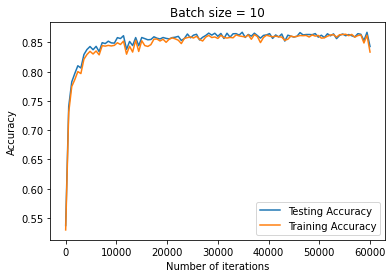

In [40]:
#plot for accuracy vs epochs

plt.plot(iteration_counter, test_acc, label = "Testing Accuracy")
plt.plot(iteration_counter, train_acc, label = "Training Accuracy")
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy")
plt.title("Batch size = "+str(b))
plt.legend(loc=4)
plt.show()

# Neural net

In [47]:
#function to fund relu
def relu(x):
    return np.maximum(x,0)

In [46]:
#function to make the prediction
def predict(w,U,x):
    return sigmoid(w.dot(relu(U.dot(x))))

In [45]:
#Calculating quadratic loss
def loss(w,U,Y,X):
    return npl.norm(Y-predict(w,U,X))**2

In [48]:
#forward propagation
def forward(x,w,v):
    l1 = w@x
    l1_func = relu(l1)
    l2 = l1_func@v
    return l1, l1_func, l2

In [49]:
#testing function
def test_neural(datax,datay,w,v):
    pred = []
    
    for x,y in zip(datax, datay):
        l1,l1_f,l2 = forward(x,w,v)
        pred.append(l2)
        
    pred = [1 if i>0.5 else 0 for i in pred]
    c = 0
    for x,y in zip(pred, datay):
        if x==y: 
            c+=1
    return c/len(pred)

In [63]:
#setting the neural net dimensions, learning rate, batch size and number of iterations
k=200
d=785
n=0.001
b=10
itrs = 60000


#initializing the weight vectors (w,v) using xavier initialization
w=np.random.normal(loc=0.0, scale=(1/d)**0.5, size=(k,d))  
v=np.random.normal(loc=0.0, scale=(1/k)**0.5, size=(k,))  

In [64]:
iteration_counter =[]
test_acc = []
train_acc = []

for i in tqdm(range(itrs+1)):
    #picking random images from the dataset for the specified batch size
    cur_batch = np.random.randint(0, high = 60000, size = b)
    
    xdata = X_train[cur_batch]
    ydata = Y_train[cur_batch]
    gw =0
    gv =0
    
    for x,y in zip(xdata, ydata):
        l1,l1_f,l2 = forward(x,w,v)
        #back prop
        gv+=(l2 - y)*(l1_f)
        relu_der = np.heaviside(l1,0)
        temp = v*relu_der
        gw+= (l2 - y)*(temp.reshape((k,1))@x.reshape((1,785)))
    
    #calculating accuracy
    if i%1000==0:
        #finding the training accuracy
        l1 = test_neural(X_train, Y_train, w, v)
        train_acc.append(l1)
        
        #finding the testing accuracy
        l = test_neural(X_test, Y_test, w, v)
        test_acc.append(l)
        iteration_counter.append(i)
    
    #update step for weights
    v-=(n/b)*gv
    w-=(n/b)*gw

100%|████████████████████████████████████████| 60001/60001 [19:48<00:00, 50.47it/s]


Accuracy = 92.36%


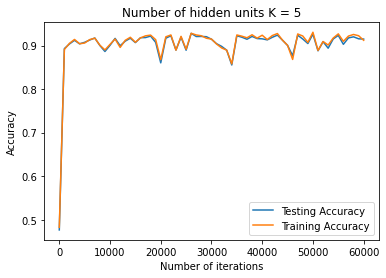

In [56]:
plt.plot(iteration_counter, test_acc, label = "Testing Accuracy")
plt.plot(iteration_counter, train_acc, label = "Training Accuracy")
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy")
plt.title("Number of hidden units K = "+str(k))
plt.legend(loc=4)
accuracy = test_neural(X_test,Y_test,w,v)
print("Accuracy = "+str(round(accuracy*100,4))+"%")

Accuracy = 97.66%


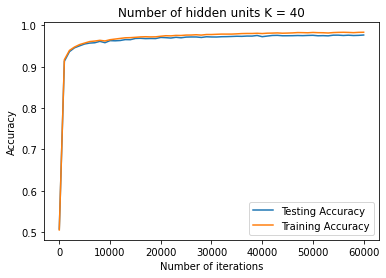

In [62]:
plt.plot(iteration_counter, test_acc, label = "Testing Accuracy")
plt.plot(iteration_counter, train_acc, label = "Training Accuracy")
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy")
plt.title("Number of hidden units K = "+str(k))
plt.legend(loc=4)
accuracy = test_neural(X_test,Y_test,w,v)
print("Accuracy = "+str(round(accuracy*100,4))+"%")

Accuracy = 96.45%


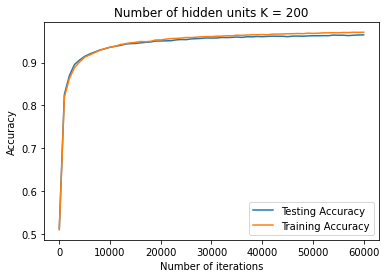

In [65]:
plt.plot(iteration_counter, test_acc, label = "Testing Accuracy")
plt.plot(iteration_counter, train_acc, label = "Training Accuracy")
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy")
plt.title("Number of hidden units K = "+str(k))
plt.legend(loc=4)
accuracy = test_neural(X_test,Y_test,w,v)
print("Accuracy = "+str(round(accuracy*100,4))+"%")

# Neural network with sigmoid and logistic loss

In [66]:
#function to calculate sigmoid
def sigmoid(x):
    return (1 / (1 + np.exp(-x)))

In [67]:
#forward propagation
def forward1(x,w,v):
    l1 = w@x
    l1_func = relu(l1)
    f_x = sigmoid(l1_func@v)
    return l1, l1_func, f_x

In [68]:
#testing function
def test_neural1(datax,datay,w,v):
    pred = []
    for x,y in zip(datax, datay):
        l1,l1_f,l2 = forward1(x,w,v)
        pred.append(l2)
        
    pred = [1 if i>0.5 else 0 for i in pred]
    c = 0
    for x,y in zip(pred, datay):
        if x==y: 
            c+=1
    return c/len(pred)

In [75]:
#setting the neural net dimensions, learning rate, batch size and number of iterations
k=200
d=785
n=0.001
b=10
itrs = 60000

#initializing the weight vectors (w,v) using xavier initialization
w=np.random.normal(loc=0.0, scale=(1/d)**0.5, size=(k,d))
v=np.random.normal(loc=0.0, scale=(1/k)**0.5, size=(k,))

In [76]:
iteration_counter =[]
test_acc = []
train_acc = []

for i in tqdm(range(itrs+1)):
    
    cur_batch = np.random.randint(0, high = 60000, size = b)
    
    xdata = X_train[cur_batch]
    ydata = Y_train[cur_batch]
    gw =0
    gv =0
    
    for x,y in zip(xdata, ydata):
        l1,l1_f,l2 = forward1(x,w,v)
        #back prop
        gv+=(sigmoid(l2) - y)*l2*(1-l2)*(l1_f)
        relu_der = np.heaviside(l1,0)
        temp = v*relu_der
        gw+= (sigmoid(l2) - y)*l2*(1-l2)*(temp.reshape((k,1))@x.reshape((1,785)))
    
    #calculating accuracy
    if i%1000==0:
        #training accuracy
        l1 = test_neural1(X_train, Y_train, w, v)
        train_acc.append(l1)
        #testing accuracy
        l = test_neural1(X_test, Y_test, w, v)
        test_acc.append(l)
        iteration_counter.append(i)
    
    #update step for weights
    v-=(n/b)*gv
    w-=(n/b)*gw

100%|████████████████████████████████████████| 60001/60001 [24:00<00:00, 41.66it/s]


Accuracy = 94.22%


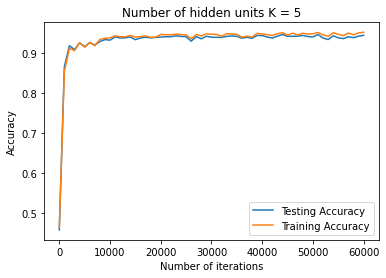

In [71]:
plt.plot(iteration_counter, test_acc, label = "Testing Accuracy")
plt.plot(iteration_counter, train_acc, label = "Training Accuracy")
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy")
plt.title("Number of hidden units K = "+str(k))
plt.legend(loc=4)
accuracy = test_neural1(X_test,Y_test,w,v)
print("Accuracy = "+str(round(accuracy*100,4))+"%")

Accuracy = 96.62%


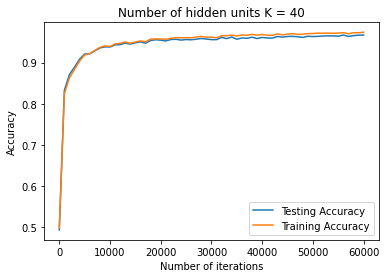

In [74]:
plt.plot(iteration_counter, test_acc, label = "Testing Accuracy")
plt.plot(iteration_counter, train_acc, label = "Training Accuracy")
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy")
plt.title("Number of hidden units K = "+str(k))
plt.legend(loc=4)
accuracy = test_neural1(X_test,Y_test,w,v)
print("Accuracy = "+str(round(accuracy*100,4))+"%")

Accuracy = 93.21%


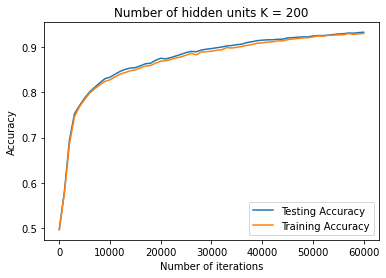

In [77]:
plt.plot(iteration_counter, test_acc, label = "Testing Accuracy")
plt.plot(iteration_counter, train_acc, label = "Training Accuracy")
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy")
plt.title("Number of hidden units K = "+str(k))
plt.legend(loc=4)
accuracy = test_neural1(X_test,Y_test,w,v)
print("Accuracy = "+str(round(accuracy*100,4))+"%")